**Pix-2-Pix Model using TensorFlow and Keras**

A port of pix-2-pix model built using TensorFlow's high level `tf.keras` API.

Note: GPU is required to make this model train quickly. Otherwise it could take hours.

Original : https://www.kaggle.com/vikramtiwari/pix-2-pix-model-using-tensorflow-and-keras/notebook

## Installations

In [0]:
requirements = """
keras
git+https://www.github.com/keras-team/keras-contrib.git
matplotlib
numpy
scipy
pillow
#urllib
#skimage
scikit-image
#gzip
#pickle
"""
%store requirements > requirements.txt

Writing 'requirements' (str) to file 'requirements.txt'.


In [0]:
!pip install -r requirements.txt

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-e1d6fp2x
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-e1d6fp2x
  Stored in directory: /tmp/pip-ephem-wheel-cache-lyczwmko/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


## Data Import

In [0]:
# !mkdir datasets
# URL="https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facade.tar.gz"
# TAR_FILE="./datasets/facade.tar.gz"
# TARGET_DIR="./datasets/facade/"
# !wget -N URL -O TAR_FILE
# !mkdir TARGET_DIR
# !tar -zxvf TAR_FILE -C ./datasets/
# !rm TAR_FILE
import tensorflow as tf
import os
#_URL = 'https://drive.google.com/uc?export=download&id=1dnLTTT19YROjpjwZIZpJ1fxAd91cGBJv'
#path_to_zip = tf.keras.utils.get_file('pix2pix.zip', origin=_URL,extract=True)
#PATH = os.path.join(os.path.dirname(path_to_zip), 'pix2pix/')

In [0]:
PATH

'/root/.keras/datasets/facades/'

## Imports

In [0]:
import os
import datetime
import imageio
import skimage
import scipy # 
# from PIL import Image as Img
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from glob import glob
from IPython.display import Image

tf.logging.set_verbosity(tf.logging.ERROR)

datasetpath = "drive/My Drive/MidCurveNN/data/pix2pix/datasets/pix2pix/"
# # datasetpath = "./"

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
class DataLoader():
    def __init__(self, dataset_name, img_res=(256, 256)):
        self.dataset_name = dataset_name
        self.img_res = img_res
        
    def binarize(self, image):
        h, w = image.shape
        for i in range(h):
          for j in range(w):
              if image[i][j] < 195:
                image[i][j] = 0
        return image

    def load_data(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "test"
        path = glob('drive/My Drive/MidCurveNN/data/%s/datasets/%s/%s/*' % (self.dataset_name, self.dataset_name, data_type))
        #path = glob(PATH + '%s/*' % (data_type))
        batch_images = np.random.choice(path, size=batch_size)

        imgs_A = []
        imgs_B = []
        for img_path in batch_images:
            img = self.imread(img_path)
            img = self.binarize(img)
            img = np.expand_dims(img, axis=-1)
            h, w, _ = img.shape
            _w = int(w/2)
            img_A, img_B = img[:, :_w, :], img[:, _w:, :]

            #  img_A = scipy.misc.imresize(img_A, self.img_res)
            #  img_A = np.array(Img.fromarray(img_A).resize(self.img_res))
            #img_A = np.array(skimage.transform.resize(img_A,self.img_res))
            #  img_B = scipy.misc.imresize(img_B, self.img_res)
            #  img_B = np.array(Img.fromarray(img_B).resize(self.img_res))
            #img_B = np.array(skimage.transform.resize(img_B,self.img_res))

            # If training => do random flip
            if not is_testing and np.random.random() < 0.5:
                img_A = np.fliplr(img_A)
                img_B = np.fliplr(img_B)

            imgs_A.append(img_A)
            imgs_B.append(img_B)

        imgs_A = np.array(imgs_A)/127.5 - 1.
        imgs_B = np.array(imgs_B)/127.5 - 1.

        return imgs_A, imgs_B

    def load_batch(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "val"
        path = glob('drive/My Drive/MidCurveNN/data/%s/datasets/%s/%s/*' % (self.dataset_name, self.dataset_name, data_type))
        #path = glob(PATH + '%s/*' % (data_type))
        self.n_batches = int(len(path) / batch_size)

        for i in range(self.n_batches-1):
            batch = path[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []
            for img in batch:
                img = self.imread(img)
                img = self.binarize(img)
                img = np.expand_dims(img, axis=-1)
                h, w, _ = img.shape
                half_w = int(w/2)
                img_A = img[:, :half_w, :]
                img_B = img[:, half_w:, :]

                #  img_A = scipy.misc.imresize(img_A, self.img_res)
                #  img_A = np.array(Img.fromarray(img_A).resize(self.img_res))
                #img_A = np.array(skimage.transform.resize(img_A,self.img_res))
                #  img_B = scipy.misc.imresize(img_B, self.img_res)
                #  img_B = np.array(Img.fromarray(img_B).resize(self.img_res))
                #img_B = np.array(skimage.transform.resize(img_B,self.img_res))

                if not is_testing and np.random.random() > 0.5:
                        img_A = np.fliplr(img_A)
                        img_B = np.fliplr(img_B)

                imgs_A.append(img_A)
                imgs_B.append(img_B)

            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.

            yield imgs_A, imgs_B


    def imread(self, path):
        return imageio.imread(path).astype(np.float)

In [0]:
class Pix2Pix():
    def __init__(self):
        # Input shape
        self.img_rows = 256
        self.img_cols = 256
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        # Configure data loader
        self.dataset_name = 'pix2pix'
        self.data_loader = DataLoader(dataset_name=self.dataset_name,
                                      img_res=(self.img_rows, self.img_cols))


        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of G and D
        self.gf = int(self.img_rows/4) # 64
        self.df = int(self.img_rows/4) # 64

        optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        #-------------------------
        # Construct Computational
        #   Graph of Generator
        #-------------------------

        # Build the generator
        self.generator = self.build_generator()

        # Input images and their conditioning images
        img_A = tf.keras.layers.Input(shape=self.img_shape)
        img_B = tf.keras.layers.Input(shape=self.img_shape)

        # By conditioning on B generate a fake version of A
        #fake_A = self.generator(img_B)

        #By conditioning on A generate a fake version of B
        fake_B = self.generator(img_A)
        
        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # Discriminators determines validity of translated images / condition pairs
        #valid = self.discriminator([fake_A, img_B])
        
        valid = self.discriminator([img_A, fake_B])

        self.combined = tf.keras.models.Model(inputs=[img_A, img_B], outputs=[valid, fake_B])
        self.combined.compile(loss=['mse', 'mae'],
                              loss_weights=[1, 100],
                              optimizer=optimizer)

    def build_generator(self):
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4, bn=True):
            """Layers used during downsampling"""
            d = tf.keras.layers.Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
            if bn:
                d = tf.keras.layers.BatchNormalization(momentum=0.8)(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = tf.keras.layers.UpSampling2D(size=2)(layer_input)
            u = tf.keras.layers.Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = tf.keras.layers.Dropout(dropout_rate)(u)
            u = tf.keras.layers.BatchNormalization(momentum=0.8)(u)
            u = tf.keras.layers.Concatenate()([u, skip_input])
            return u

        # Image input
        d0 = tf.keras.layers.Input(shape=self.img_shape)

        # Downsampling
        d1 = conv2d(d0, self.gf, bn=False)
        d2 = conv2d(d1, self.gf*2)
        d3 = conv2d(d2, self.gf*4)
        d4 = conv2d(d3, self.gf*8)
        d5 = conv2d(d4, self.gf*8)
        d6 = conv2d(d5, self.gf*8)
        d7 = conv2d(d6, self.gf*8)

        # Upsampling
        u1 = deconv2d(d7, d6, self.gf*8)
        u2 = deconv2d(u1, d5, self.gf*8)
        u3 = deconv2d(u2, d4, self.gf*8)
        u4 = deconv2d(u3, d3, self.gf*4)
        u5 = deconv2d(u4, d2, self.gf*2)
        u6 = deconv2d(u5, d1, self.gf)

        u7 = tf.keras.layers.UpSampling2D(size=2)(u6)
        output_img = tf.keras.layers.Conv2D(self.channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)

        return tf.keras.models.Model(d0, output_img)

    def build_discriminator(self):

        def d_layer(layer_input, filters, f_size=4, bn=True):
            """Discriminator layer"""
            d = tf.keras.layers.Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
            if bn:
                d = tf.keras.layers.BatchNormalization(momentum=0.8)(d)
            return d

        img_A = tf.keras.layers.Input(shape=self.img_shape)
        img_B = tf.keras.layers.Input(shape=self.img_shape)

        # Concatenate image and conditioning image by channels to produce input
        combined_imgs = tf.keras.layers.Concatenate(axis=-1)([img_A, img_B])

        d1 = d_layer(combined_imgs, self.df, bn=False)
        d2 = d_layer(d1, self.df*2)
        d3 = d_layer(d2, self.df*4)
        d4 = d_layer(d3, self.df*8)

        validity = tf.keras.layers.Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return tf.keras.models.Model([img_A, img_B], validity)

    def train(self, epochs, batch_size=1, sample_interval=50):
        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)

        for epoch in range(epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):
                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Condition on B and generate a translated version
                #fake_A = self.generator.predict(imgs_B)

                #Condition on A and generate a translated version
                fake_B = self.generator.predict(imgs_A)

                # Train the discriminators (original images = real / generated = Fake)
                d_loss_real = self.discriminator.train_on_batch([imgs_A, imgs_B], valid)
                d_loss_fake = self.discriminator.train_on_batch([imgs_A, fake_B], fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # -----------------
                #  Train Generator
                # -----------------

                # Train the generators
                g_loss = self.combined.train_on_batch([imgs_A, imgs_B], [valid, imgs_B])

                elapsed_time = datetime.datetime.now() - start_time
                # Plot the progress
                print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %f] time: %s" % (epoch, epochs,
                                                                        batch_i, self.data_loader.n_batches,
                                                                        d_loss[0], 100*d_loss[1],
                                                                        g_loss[0],
                                                                        elapsed_time))

                # If at save interval => save generated image samples
                if batch_i % sample_interval == 0:
                    self.sample_images(epoch, batch_i)

    def sample_images(self, epoch, batch_i):
        os.makedirs('drive/My Drive/MidCurveNN/pix2pix/images/%s' % self.dataset_name, exist_ok=True)
        r, c = 3, 3

        imgs_A, imgs_B = self.data_loader.load_data(batch_size=3, is_testing=True)
        fake_B = self.generator.predict(imgs_A)

        gen_imgs = np.concatenate([imgs_A, fake_B, imgs_B])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Condition', 'Generated', 'Original']
        fig, axs = plt.subplots(r, c, figsize=(15,15))
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt][:,:,0], cmap='gray')
                axs[i, j].set_title(titles[i])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("drive/My Drive/MidCurveNN/pix2pix/images/%s/%d_%d.png" % (self.dataset_name, epoch, batch_i))
        plt.close()

In [0]:
gan = Pix2Pix()
# gan.train(epochs=200, batch_size=1, sample_interval=200)

In [0]:
gan.train(epochs=5, batch_size=1, sample_interval=200)
# training logs are hidden in published notebook

[Epoch 0/5] [Batch 0/268] [D loss: 19.569597, acc:  65%] [G loss: 89.946404] time: 0:00:09.771924
[Epoch 0/5] [Batch 1/268] [D loss: 12.837976, acc:  23%] [G loss: 75.910683] time: 0:00:13.163693
[Epoch 0/5] [Batch 2/268] [D loss: 6.309819, acc:  76%] [G loss: 60.482128] time: 0:00:13.762361
[Epoch 0/5] [Batch 3/268] [D loss: 1.175568, acc:  43%] [G loss: 51.362778] time: 0:00:14.343378
[Epoch 0/5] [Batch 4/268] [D loss: 2.133279, acc:  71%] [G loss: 38.794521] time: 0:00:14.928327
[Epoch 0/5] [Batch 5/268] [D loss: 2.058104, acc:  53%] [G loss: 34.190201] time: 0:00:15.515869
[Epoch 0/5] [Batch 6/268] [D loss: 3.919171, acc:  17%] [G loss: 31.429901] time: 0:00:16.102495
[Epoch 0/5] [Batch 7/268] [D loss: 1.348486, acc:  44%] [G loss: 28.080292] time: 0:00:16.692610
[Epoch 0/5] [Batch 8/268] [D loss: 1.975489, acc:  23%] [G loss: 28.794367] time: 0:00:17.277123
[Epoch 0/5] [Batch 9/268] [D loss: 2.094713, acc:  47%] [G loss: 28.088181] time: 0:00:17.863818
[Epoch 0/5] [Batch 10/268] [

Let's see how our model performed over time.

In [0]:
from PIL import Image as Img

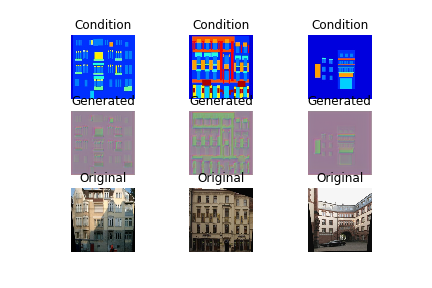

In [0]:
Image('./images/facades/0_0.png')

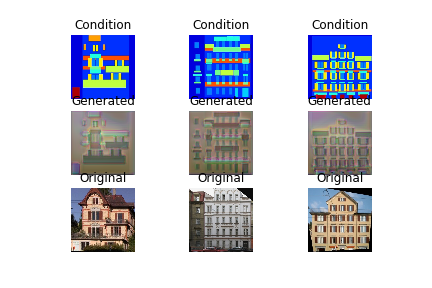

In [0]:
Img('./images/facades/0_200.png')

In [0]:
Image('./images/facades/5_200.png')

In [0]:
Img('./images/facades/9_200.png')

This is the result of 10 iterations. You can train the model for more than 10 iterations and it will produce better results. Also, try this model with different datasets.